In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time
from datetime import datetime
warnings.filterwarnings('ignore')

##调取若干模型
from sklearn import linear_model
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
#相关系数分析
def draw_scatter(x, y, colname, name, corr):
    plt.figure(figsize=(4, 2.5), dpi=300)
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.tick_params(labelsize=3)
    plt.scatter(x, y, s=3)
    plt.xlabel("Price", fontsize=3)
    plt.ylabel(colname, fontsize=3)
    plt.title("price与"+colname +"相关系数："+str(round(corr,2)))
    plt.savefig("C:/Users/12594/Desktop/BuyCarAnalyse/data/" + name + ".png")
    plt.show()

#日期读取
def cal_days(date):
    try:
        date = datetime.strptime(str(date), '%Y%m%d')
    except:
        year = str(date)[:4]
        month = int(str(date)[4:6])
        day = int(str(date)[6:])
        if month < 1:
            month = "01"
        elif month > 12:
            month = "12"
        if day < 1:
            day = "01"
        elif day > 31:
            day = "31"
        date = datetime.strptime(str(year)+str(month)+str(day), '%Y%m%d')
    return (datetime.now()-date).days


In [3]:
## 通过Pandas对于数据进行读取 
Train_data = pd.read_csv(r'C:/Users/12594/Desktop/project/used_car_train_20200313.csv', index_col=0, sep=' ')
Test_data = pd.read_csv(r'C:/Users/12594/Desktop/project/used_car_testB_20200421.csv',  index_col=0, sep=' ')

## 输出数据的大小信息
print('Train data shape:',Train_data.shape)
print('Test data shape:',Test_data.shape)

Train_data["regDays"] = Train_data["regDate"].apply(cal_days)
Train_data["createDays"] = Train_data["creatDate"].apply(cal_days)
Test_data["regDays"] = Test_data["regDate"].apply(cal_days)
Test_data["createDays"] = Test_data["creatDate"].apply(cal_days)

#带入先验知识，选择相关列
col_names = ["gearbox","regDays","power","kilometer","createDays", "v_0", "v_1", "v_2", "v_3", "v_4", "v_5", "v_6", "v_7", "v_8", "v_9", "v_10", "v_11", "v_12", "v_13", "v_14"]
related_colnames = []
#related_colnames = ['model', 'gearbox', 'power', 'kilometer',  'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']
for colname in col_names:
    corr = Train_data[["price", colname]].corr()["price"].tolist()[1]
    if abs(corr) >= 0.1:
        related_colnames.append(colname)
    #draw_scatter(x=Train_data["price"], y=Train_data[colname], colname=colname, corr=corr, name="Price与"+colname+"关系图")
print(related_colnames)

Train data shape: (150000, 30)
Test data shape: (50000, 29)
['gearbox', 'regDays', 'power', 'kilometer', 'v_0', 'v_3', 'v_4', 'v_5', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12']


In [4]:
##初始化训练样本与对应值+测试样本
X_data = Train_data[related_colnames]
Y_data = Train_data['price']
X_test  = Test_data[related_colnames]
print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)

X train shape: (150000, 13)
X test shape: (50000, 13)


In [5]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 200000 to 249999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gearbox    48032 non-null  float64
 1   regDays    50000 non-null  int64  
 2   power      50000 non-null  int64  
 3   kilometer  50000 non-null  float64
 4   v_0        50000 non-null  float64
 5   v_3        50000 non-null  float64
 6   v_4        50000 non-null  float64
 7   v_5        50000 non-null  float64
 8   v_8        50000 non-null  float64
 9   v_9        50000 non-null  float64
 10  v_10       50000 non-null  float64
 11  v_11       50000 non-null  float64
 12  v_12       50000 non-null  float64
dtypes: float64(11), int64(2)
memory usage: 5.3 MB


In [6]:
#统计函数
def get_info(data):
    print('最小值：',np.min(data))
    print('最大值：',np.max(data))
    print('平均值:',np.mean(data))
    print('方差:',np.var(data))

In [7]:
print('训练集价格分布情况')
get_info(Y_data)

训练集价格分布情况
最小值： 11
最大值： 99999
平均值: 5923.327333333334
方差: 56279605.942732885


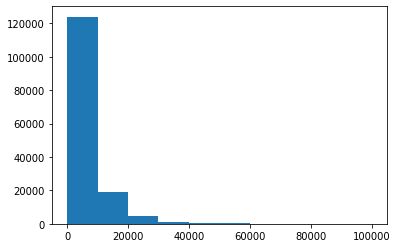

In [8]:
#查看统计分布
plt.hist(Y_data)
plt.show()
plt.close()

In [9]:
#去掉NaN
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

In [10]:
##若干模型函数
#线性回归
def build_model_lin(x_train,y_train):
    linreg = LinearRegression()
    model = linreg.fit(x_train,y_train)
    return model
#GradientTree Boosting
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=9) 
    objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 150)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

def build_model_gbr(x_train,y_train):
    gbrreg = GradientBoostingRegressor(n_estimators=150,learning_rate=0.1,max_depth=5)
    model = gbrreg.fit(x_train,y_train)
    return model

def build_model_rfr(x_train,y_train):
    rfrreg =  RandomForestRegressor(n_jobs = 1,random_state =1)#n_estimator = 100
    model = rfrreg.fit(x_train,y_train)
    return model

def build_model_sgd(x_train,y_train):
    sgdreg = SGDRegressor(max_iter=3000)
    model = sgdreg.fit(x_train,y_train)
    return model
    

In [11]:
'''
##五折交叉验证查看参数效果lgb
scores_train = []
scores = []
sk = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,test_ind in sk.split(X_data,Y_data):
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    test_x=X_data.iloc[test_ind].values
    test_y=Y_data.iloc[test_ind]
    model=build_model_lgb(train_x,train_y)
    model.fit(train_x,train_y)
    pred_train_lgb=model.predict(train_x)
    pred_lgb=model.predict(test_x)
    
    score_train = mean_absolute_error(train_y,pred_train_lgb)
    scores_train.append(score_train)
    score = mean_absolute_error(test_y,pred_lgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('test mae',np.mean(scores))
'''

"\n##五折交叉验证查看参数效果lgb\nscores_train = []\nscores = []\nsk = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)\nfor train_ind,test_ind in sk.split(X_data,Y_data):\n    train_x=X_data.iloc[train_ind].values\n    train_y=Y_data.iloc[train_ind]\n    test_x=X_data.iloc[test_ind].values\n    test_y=Y_data.iloc[test_ind]\n    model=build_model_lgb(train_x,train_y)\n    model.fit(train_x,train_y)\n    pred_train_lgb=model.predict(train_x)\n    pred_lgb=model.predict(test_x)\n    \n    score_train = mean_absolute_error(train_y,pred_train_lgb)\n    scores_train.append(score_train)\n    score = mean_absolute_error(test_y,pred_lgb)\n    scores.append(score)\n\nprint('Train mae:',np.mean(score_train))\nprint('test mae',np.mean(scores))\n"

In [12]:
'''
##五折交叉验证查看参数效果xgb
scores_train = []
scores = []
sk = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,test_ind in sk.split(X_data,Y_data):
    
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    test_x=X_data.iloc[test_ind].values
    test_y=Y_data.iloc[test_ind]
    
    model=build_model_xgb(train_x,train_y)
    model.fit(train_x,train_y)
    pred_train_xgb=model.predict(train_x)
    pred_xgb=model.predict(test_x)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(test_y,pred_xgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))
'''

"\n##五折交叉验证查看参数效果xgb\nscores_train = []\nscores = []\nsk = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)\nfor train_ind,test_ind in sk.split(X_data,Y_data):\n    \n    train_x=X_data.iloc[train_ind].values\n    train_y=Y_data.iloc[train_ind]\n    test_x=X_data.iloc[test_ind].values\n    test_y=Y_data.iloc[test_ind]\n    \n    model=build_model_xgb(train_x,train_y)\n    model.fit(train_x,train_y)\n    pred_train_xgb=model.predict(train_x)\n    pred_xgb=model.predict(test_x)\n    \n    score_train = mean_absolute_error(train_y,pred_train_xgb)\n    scores_train.append(score_train)\n    score = mean_absolute_error(test_y,pred_xgb)\n    scores.append(score)\n\nprint('Train mae:',np.mean(score_train))\nprint('Val mae',np.mean(scores))\n"

In [13]:
'''
##五折交叉验证查看参数效果rfr
scores_train = []
scores = []
sk = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,test_ind in sk.split(X_data,Y_data):
    
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    test_x=X_data.iloc[test_ind].values
    test_y=Y_data.iloc[test_ind]
    
    model=build_model_rfr(train_x,train_y)
    model.fit(train_x,train_y)
    pred_train_rfr=model.predict(train_x)
    pred_rfr=model.predict(test_x)
    
    score_train = mean_absolute_error(train_y,pred_train_rfr)
    scores_train.append(score_train)
    score = mean_absolute_error(test_y,pred_rfr)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))
'''

"\n##五折交叉验证查看参数效果rfr\nscores_train = []\nscores = []\nsk = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)\nfor train_ind,test_ind in sk.split(X_data,Y_data):\n    \n    train_x=X_data.iloc[train_ind].values\n    train_y=Y_data.iloc[train_ind]\n    test_x=X_data.iloc[test_ind].values\n    test_y=Y_data.iloc[test_ind]\n    \n    model=build_model_rfr(train_x,train_y)\n    model.fit(train_x,train_y)\n    pred_train_rfr=model.predict(train_x)\n    pred_rfr=model.predict(test_x)\n    \n    score_train = mean_absolute_error(train_y,pred_train_rfr)\n    scores_train.append(score_train)\n    score = mean_absolute_error(test_y,pred_rfr)\n    scores.append(score)\n\nprint('Train mae:',np.mean(score_train))\nprint('Val mae',np.mean(scores))\n"

In [14]:
#改变n_estimators
#10: 0min11s 2134/2146
#30: 0min32s 664/749 
#50: 0min51s 573/689
#90: 1min28s 532/675
#110:1min47s 515/669
#160:2min36s 477/658

In [15]:
## 切分数据集（Train,test）进行模型训练，评价和预测
x_train,x_test,y_train,y_test = train_test_split(X_data,Y_data,test_size=0.3)

In [16]:
print('Train lgb...')
model_lgb = build_model_lgb(x_train,y_train)
y_lgb = model_lgb.predict(x_test)
MAE_lgb = mean_absolute_error(y_test,y_lgb)
print('MAE of val with lgb:',MAE_lgb)

#print('Predict lgb...')
model_lgb_pre = build_model_lgb(X_data,Y_data)
Y_lgb = model_lgb_pre.predict(X_test)
#print('Sta of Predict lgb:')
#Sta_inf(Y_lgb) 
#150：677

Train lgb...
MAE of val with lgb: 672.4114754656352


In [17]:
print('Train xgb...')
model_xgb = build_model_xgb(x_train,y_train)
y_xgb = model_xgb.predict(x_test)
MAE_xgb = mean_absolute_error(y_test,y_xgb)
print('MAE of val with xgb:',MAE_xgb)

#print('Predict xgb...')
model_xgb_pre = build_model_xgb(X_data,Y_data)
Y_xgb = model_xgb_pre.predict(X_test)
#print('Sta of Predict xgb:')
#Sta_inf(subA_xgb)

Train xgb...
[20:21:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE of val with xgb: 661.3877872580429
[20:22:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [18]:
'''
print('Train sgd...')
model_sgd = build_model_sgd(x_train,y_train)
y_sgd = model_sgd.predict(x_test)
MAE_sgd = mean_absolute_error(y_test,y_sgd)
print('MAE of val with sgd:',MAE_sgd)

#print('Predict xgb...')
model_sgd_pre = build_model_sgd(X_data,Y_data)
Y_lin = model_sgd_pre.predict(X_test)
#print('Sta of Predict xgb:')
#Sta_inf(subA_xgb)
#106117188032967
#775901829383128
#343632468679040
'''

"\nprint('Train sgd...')\nmodel_sgd = build_model_sgd(x_train,y_train)\ny_sgd = model_sgd.predict(x_test)\nMAE_sgd = mean_absolute_error(y_test,y_sgd)\nprint('MAE of val with sgd:',MAE_sgd)\n\n#print('Predict xgb...')\nmodel_sgd_pre = build_model_sgd(X_data,Y_data)\nY_lin = model_sgd_pre.predict(X_test)\n#print('Sta of Predict xgb:')\n#Sta_inf(subA_xgb)\n#106117188032967\n#775901829383128\n#343632468679040\n"

In [19]:
'''
print('Train gbr...')
model_gbr = build_model_gbr(x_train,y_train)
y_gbr = model_gbr.predict(x_test)
MAE_gbr = mean_absolute_error(y_test,y_gbr)
print('MAE of val with gbr:',MAE_gbr)

#print('Predict xgb...')
model_gbr_pre = build_model_gbr(X_data,Y_data)
Y_gbr = model_gbr_pre.predict(X_test)
#print('Sta of Predict xgb:')
#Sta_inf(subA_xgb)
'''

"\nprint('Train gbr...')\nmodel_gbr = build_model_gbr(x_train,y_train)\ny_gbr = model_gbr.predict(x_test)\nMAE_gbr = mean_absolute_error(y_test,y_gbr)\nprint('MAE of val with gbr:',MAE_gbr)\n\n#print('Predict xgb...')\nmodel_gbr_pre = build_model_gbr(X_data,Y_data)\nY_gbr = model_gbr_pre.predict(X_test)\n#print('Sta of Predict xgb:')\n#Sta_inf(subA_xgb)\n"

In [20]:
print('Train rfr...')
model_rfr = build_model_rfr(x_train,y_train)
y_rfr = model_rfr.predict(x_test)
MAE_rfr = mean_absolute_error(y_test,y_rfr)
print('MAE of val with rfr:',MAE_rfr)

#print('Predict xgb...')
model_rfr_pre = build_model_rfr(X_data,Y_data)
Y_rfr = model_rfr_pre.predict(X_test)
#print('Sta of Predict xgb:')
#Sta_inf(subA_xgb)

Train rfr...
MAE of val with rfr: 665.6177123021164


In [21]:
##使用rfr，xgb，lgb这三种模型混合
sum_weight = MAE_rfr + MAE_xgb + MAE_lgb
rfr_weight = 1-2*MAE_rfr/sum_weight
xgb_weight = 1-2*MAE_xgb/sum_weight
lgb_weight = 1-2*MAE_lgb/sum_weight
y_mix = rfr_weight*y_rfr + xgb_weight*y_xgb + lgb_weight*y_lgb
#y_mix = (1-MAE_rfr/(MAE_xgb+MAE_rfr))*y_rfr+(1-MAE_xgb/(MAE_xgb+MAE_rfr))*y_xgb
y_mix[y_mix<0]=10 # 由于我们发现预测的最小值有负数，而真实情况下，price为负是不存在的，由此我们进行对应的后修正
print('MAE of mixed weight:',mean_absolute_error(y_test,y_mix))

MAE of mixed weight: 643.9948149110077


预测结果中价格的统计数据如下：
最小值： 10.0
最大值： 90725.75410901807
平均值: 5907.118228648457
方差: 53263008.83378503


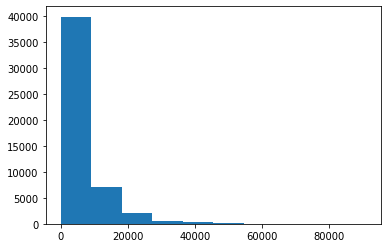

训练样本中价格的统计数据如下：
最小值： 11
最大值： 99999
平均值: 5923.327333333334
方差: 56279605.942732885


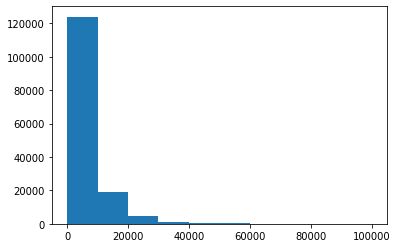

In [22]:
Y_mix = rfr_weight*Y_rfr + xgb_weight*Y_xgb + lgb_weight*Y_lgb
Y_mix[Y_mix<0]=10
print('预测结果中价格的统计数据如下：')
get_info(Y_mix)
plt.hist(Y_mix)
plt.show()
plt.close()
print('训练样本中价格的统计数据如下：')
get_info(Y_data)
## 查看预测值的统计进行
plt.hist(Y_data)
plt.show()
plt.close()

In [23]:
sub = pd.DataFrame()
sub['SaleID'] = X_test.index
sub['price'] = Y_mix
sub.to_csv('C:/Users/12594/Desktop/project/Final.csv',index=False)